Covid Stuff
====

Let's see if we can find any correlation between cases + deaths for the spread of covid in the UK

First we need to download our data and get it into a nice form. Then we can plot it to see if it's what we expect

In [1]:
import requests
import json
import matplotlib.pyplot as plt


# This URL will let us download a json dump of covid cases and deaths by date
url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=json"

# Store the data in a str. We can get away with this because it's small
covid_data_json = requests.get(url).content

# Parse the json str
covid_data = json.loads(covid_data_json)["body"]

dates = [x["date"] for x in covid_data]
cases = [x["newCasesBySpecimenDate"] for x in covid_data]
deaths = [x["newDeaths28DaysByDeathDate"] for x in covid_data]

cases = [x if x else 0 for x in cases]
deaths = [x if x else 0 for x in deaths]  # mess

dates.reverse()
cases.reverse()
deaths.reverse()
date_num = [i for i, _ in enumerate(dates)]


def plot(cases, deaths, dates):
    plt.clf()
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(date_num, cases, label="cases", color="r")
    ax[1].plot(date_num, deaths, label="deaths", color="k")
    ax[0].legend()
    ax[1].legend()
    ax[1].set_xlabel("Day")


plot(cases, deaths, date_num)

There was way less testing in the first wave, which is annoying

We could scale it up, but instead let's only consider the second/third wave(s)

<Figure size 432x288 with 0 Axes>

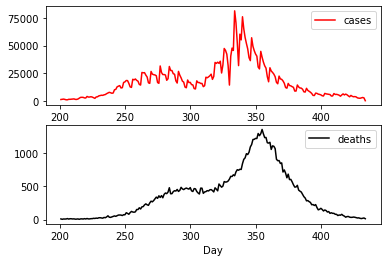

In [2]:
import numpy as np

cases = np.array(cases, dtype=np.int32)
deaths = np.array(deaths)
date_num = np.array(date_num)

cases = cases[date_num > 200]
deaths = deaths[date_num > 200]
date_num = date_num[date_num > 200]

plot(cases, deaths, date_num)

The cases graph is really spiky because of the weekly variation in reporting - let's smooth it out with a gaussian filter.

Let's also apply the same filter to the deaths graph.

<Figure size 432x288 with 0 Axes>

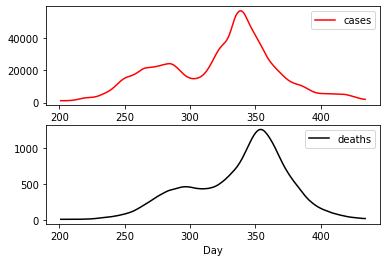

In [3]:
from scipy import ndimage


kernel_sigma = 3.5

smooth_cases = ndimage.gaussian_filter1d(cases, sigma=kernel_sigma)
smooth_deaths = ndimage.gaussian_filter1d(deaths, sigma=kernel_sigma)

plot(smooth_cases, smooth_deaths, date_num)

Now we're in a position to find the correlation between these two graphs. This will tell us approximately how long a case takes to turn into a death.

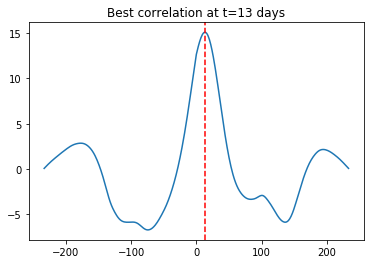

In [4]:
from scipy import signal

# Normalise to the same scale. Just in case
smooth_cases_norm = smooth_cases / max(smooth_cases)
smooth_deaths_norm = smooth_deaths / max(smooth_deaths)

# Find the correlation
corr = signal.correlate(
    smooth_deaths_norm - np.mean(smooth_deaths_norm),
    smooth_cases_norm - np.mean(smooth_cases_norm),
    method="auto",
)

# Weird index convention
offset = len(smooth_cases_norm) - 1

t = [i - offset for i, _ in enumerate(corr)]
lag = corr.argmax() - (len(smooth_cases_norm) - 1)

plt.figure()
plt.plot(t, corr)

plt.axvline(lag, color="r", linestyle="--")
plt.title(f"Best correlation at t={lag} days")
None